<a href="https://www.kaggle.com/code/ashioyajotham/ai4d-tourism-classification?scriptVersionId=99611211" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [151]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai4d-africas-anglophone-research/SampleSubmission.csv
/kaggle/input/ai4d-africas-anglophone-research/continents.csv
/kaggle/input/ai4d-africas-anglophone-research/Train.csv
/kaggle/input/ai4d-africas-anglophone-research/VariableDefinitions.csv
/kaggle/input/ai4d-africas-anglophone-research/Test.csv


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_auc_score, \
confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [153]:
train = pd.read_csv("../input/ai4d-africas-anglophone-research/Train.csv")
pd.set_option("display.max_columns", None)
train.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,Yes,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


In [154]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

In [155]:
train.isnull().sum()

Tour_ID                     0
country                     0
age_group                   0
travel_with              1075
total_female                2
total_male                  6
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category               0
dtype: int64

In [156]:
train["travel_with"].value_counts()

Alone                           7590
With Spouse                     4842
With Other Friends/Relatives    3268
With Spouse and Children        1193
With Children                    538
Name: travel_with, dtype: int64

In [157]:
train["travel_with"].fillna("Alone", inplace = True)
train['travel_with'].isnull().any()

False

In [158]:
train["total_female"].fillna(train["total_female"].mean(), inplace = True)
train["total_female"].isnull().any()

False

### Feature Engineering
* Country ISO Code
* Continent

In [159]:
train.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category'],
      dtype='object')

In [160]:
train.rename(columns={"total_female":"female","total_male":"male", "most_impressing":"feedback"}, inplace = True)
train.country = train.country.replace("SWIZERLAND", "SWITZERLAND")

!pip install country-converter
import country_converter as coco

cc = coco.CountryConverter()
iso3 = np.array([])
for i in range(0, len(train)):
    iso3= np.append(iso3, cc.convert(names=train['country'][i], to='ISO3' ))
train['ISO3'] = pd.DataFrame(iso3) 

In [161]:
train["tot_nights"] = train["night_mainland"] + train["night_zanzibar"]
train["fam"] = train["female"] + train["male"]
train.columns
train = train[['Tour_ID', 'country', 'ISO3','age_group', 'travel_with', 'female', 'male',
       'fam', 'purpose', 'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'tot_nights',
       'first_trip_tz', 'cost_category']]

train.head()

,Tour_ID,country,ISO3,age_group,travel_with,female,male,fam,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,tot_nights,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,ITA,45-64,With Children,0.0,2.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,Yes,Yes,Yes,Yes,No,No,No,0,7,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,GBR,25-44,With Spouse,1.0,1.0,2.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,No,No,0,7,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,USA,65+,With Spouse,1.0,1.0,2.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,No,6,6,12,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,RWA,25-44,With Spouse and Children,3.0,1.0,4.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,0,3,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,USA,45-64,Alone,0.0,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,Yes,Yes,7,0,7,Yes,Higher Cost


In [162]:
train.shape

(18506, 24)

### Checking for high- and -low cardinality categorical variables 

In [163]:
train.select_dtypes("object").head()

,Tour_ID,country,ISO3,age_group,travel_with,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,ITA,45-64,With Children,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,Yes,Yes,Yes,Yes,No,No,No,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,GBR,25-44,With Spouse,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,No,No,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,USA,65+,With Spouse,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,RWA,25-44,With Spouse and Children,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,USA,45-64,Alone,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Higher Cost


In [164]:
train.select_dtypes("object").nunique()

Tour_ID                  18506
country                    131
ISO3                       122
age_group                    5
travel_with                  5
purpose                      8
main_activity               10
info_source                  8
tour_arrangement             2
package_transport_int        2
package_accomodation         2
package_food                 2
package_transport_tz         2
package_sightseeing          2
package_guided_tour          2
package_insurance            2
first_trip_tz                2
cost_category                6
dtype: int64

### Check for multicollinearity

In [165]:
num_cols = ["age_group", "female", "male"]

corr = train[num_cols].corr()
corr

,female,male
female,1.000000,0.416954
male,0.416954,1.000000


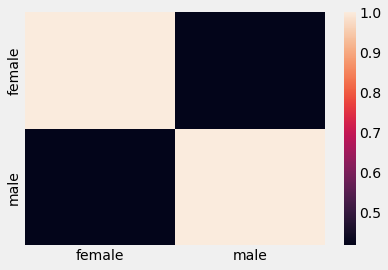

In [166]:
sns.heatmap(corr);

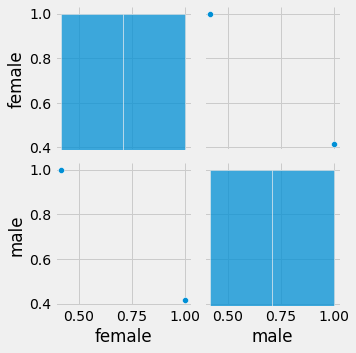

In [167]:
plt.style.use("fivethirtyeight")
sns.pairplot(corr);

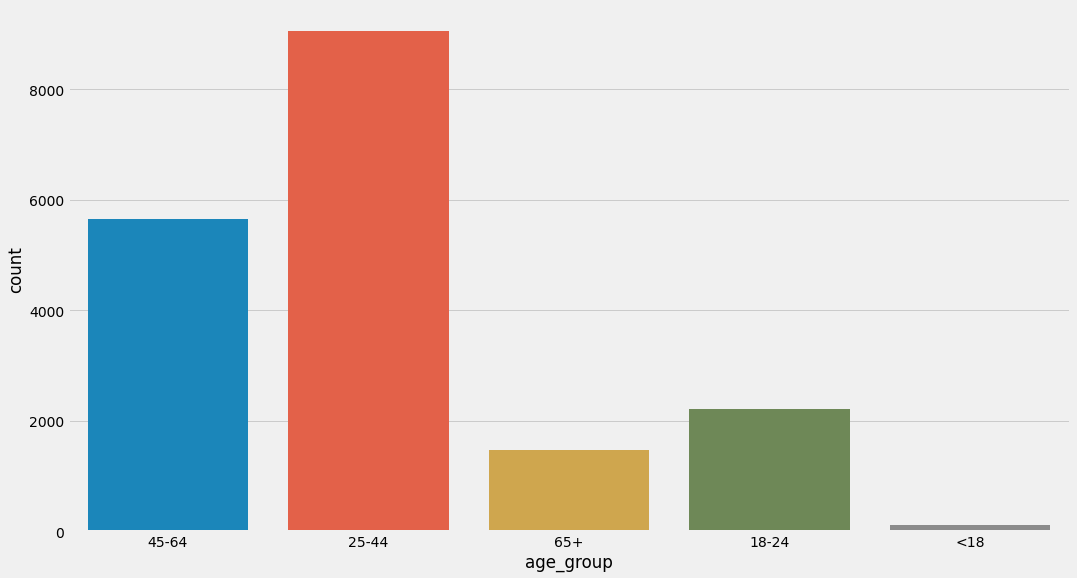

In [168]:
# Biggest Age Group
plt.figure(figsize = (16,9))
sns.countplot(train.age_group);

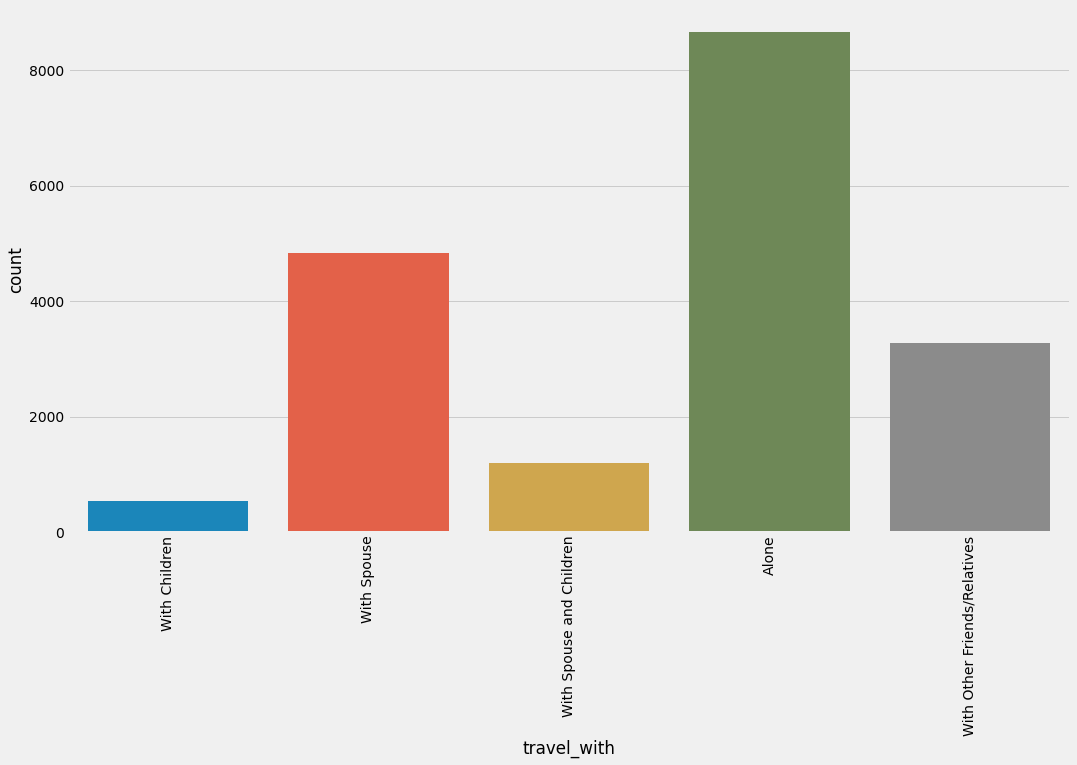

In [169]:
# Who did everyone travel with?
plt.figure(figsize = (16,9))
sns.countplot(train.travel_with)
plt.xticks(rotation = "vertical");

In [170]:
# Visiting Purpose
import wordcloud 
from wordcloud import WordCloud, STOPWORDS

def wc(data, mask=None, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update([])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,mask=mask, background_color="white").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

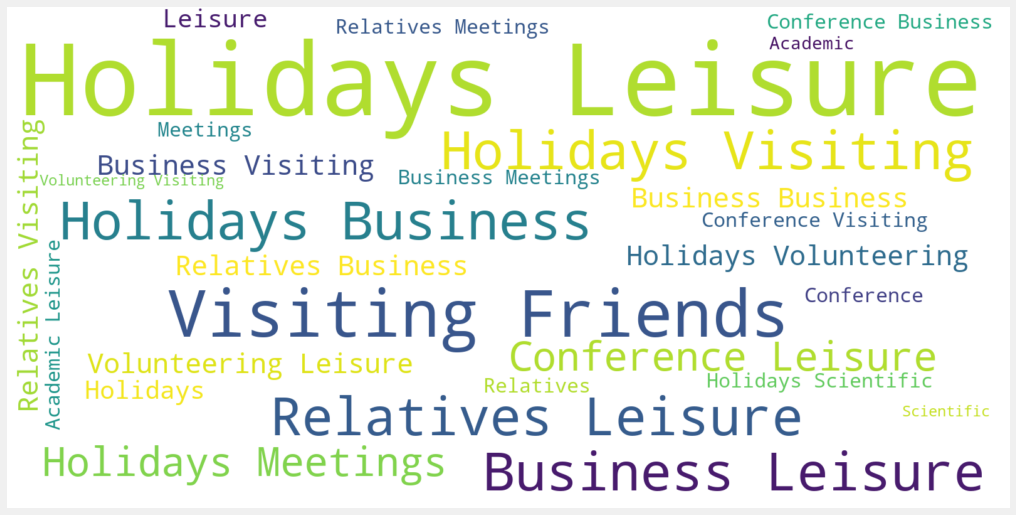

In [171]:
wc(train['purpose'], title = '', mask=None)

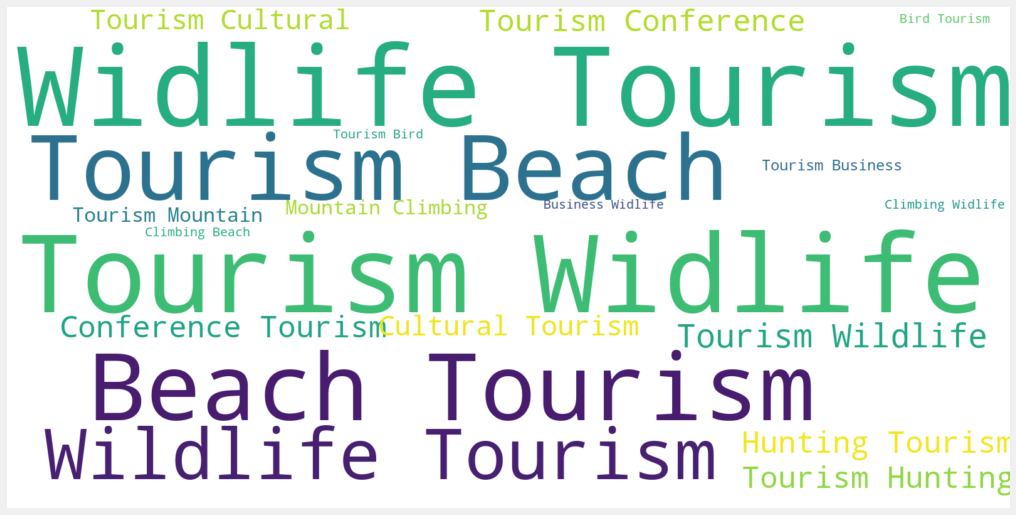

In [172]:
wc(train['main_activity'], title = '', mask=None)

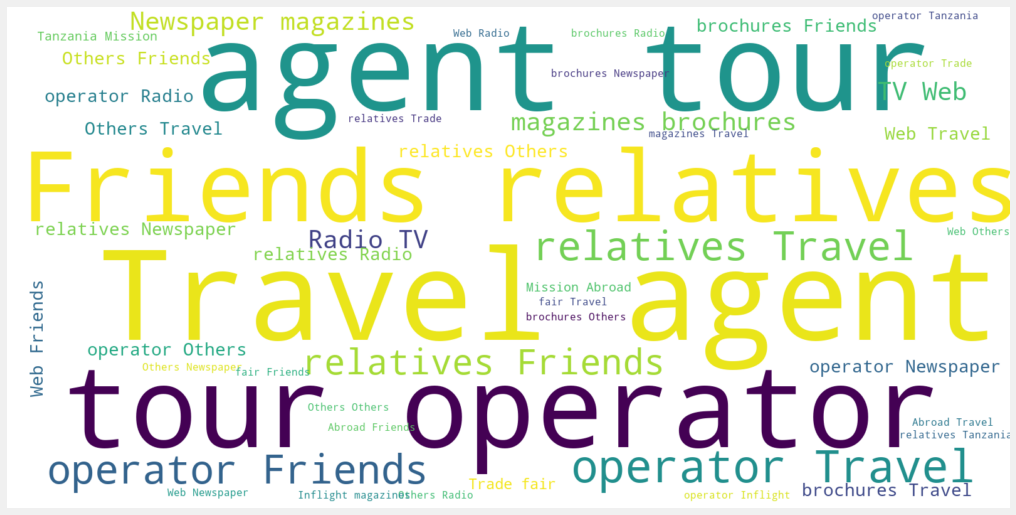

In [173]:
wc(train['info_source'], title = '', mask=None)

### Preprocessing Test Dataset

In [174]:
test = pd.read_csv("../input/ai4d-africas-anglophone-research/Test.csv")
test.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz
0,tour_idynufedne,KOREA,25-44,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,45-64,With Children,1.0,1.0,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,Yes
2,tour_idf6itml6g,ITALY,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,Yes
3,tour_id99u4znru,KENYA,25-44,Alone,0.0,1.0,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,No
4,tour_idj4i9urbx,ZAMBIA,25-44,Alone,0.0,1.0,Business,Widlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,No


In [175]:
test.shape
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6169 entries, 0 to 6168
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                6169 non-null   object 
 1   country                6169 non-null   object 
 2   age_group              6169 non-null   object 
 3   travel_with            5808 non-null   object 
 4   total_female           6167 non-null   float64
 5   total_male             6168 non-null   float64
 6   purpose                6169 non-null   object 
 7   main_activity          6169 non-null   object 
 8   info_source            6169 non-null   object 
 9   tour_arrangement       6169 non-null   object 
 10  package_transport_int  6169 non-null   object 
 11  package_accomodation   6169 non-null   object 
 12  package_food           6169 non-null   object 
 13  package_transport_tz   6169 non-null   object 
 14  package_sightseeing    6169 non-null   object 
 15  pack

In [176]:
test.rename(columns={"total_female":"female","total_male":"male"}, inplace = True)

test["travel_with"].fillna("Alone", inplace = True)
test["female"].fillna(train["female"].mean(), inplace = True)
test["male"].fillna(train["male"].mean(), inplace = True)

cc = coco.CountryConverter()
iso3 = np.array([])
for i in range(0, len(test)):
    iso3= np.append(iso3, cc.convert(names=test['country'][i], to='ISO3' ))
test['ISO3'] = pd.DataFrame(iso3) 

test["tot_nights"] = test["night_mainland"] + test["night_zanzibar"]
test["fam"] = test["female"] + test["male"]

test.columns
test = test[['Tour_ID', 'country', 'ISO3','age_group', 'travel_with', 'female', 'male', 'fam',
       'purpose', 'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'tot_nights',
       'first_trip_tz']]

test.head()

,Tour_ID,country,ISO3,age_group,travel_with,female,male,fam,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,tot_nights,first_trip_tz
0,tour_idynufedne,KOREA,KOR,25-44,Alone,0.0,1.0,1.0,Leisure and Holidays,Widlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,11,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,GBR,45-64,With Children,1.0,1.0,2.0,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,7,Yes
2,tour_idf6itml6g,ITALY,ITA,25-44,With Spouse,1.0,1.0,2.0,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,6,Yes
3,tour_id99u4znru,KENYA,KEN,25-44,Alone,0.0,1.0,1.0,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,7,No
4,tour_idj4i9urbx,ZAMBIA,ZMB,25-44,Alone,0.0,1.0,1.0,Business,Widlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,6,No


In [177]:
test.isnull().any()

Tour_ID                  False
country                  False
ISO3                     False
age_group                False
travel_with              False
female                   False
male                     False
fam                      False
purpose                  False
main_activity            False
info_source              False
tour_arrangement         False
package_transport_int    False
package_accomodation     False
package_food             False
package_transport_tz     False
package_sightseeing      False
package_guided_tour      False
package_insurance        False
night_mainland           False
night_zanzibar           False
tot_nights               False
first_trip_tz            False
dtype: bool

# Split

In [178]:
target = "cost_category"
features = [ 
"country",           
"age_group",     
"travel_with",   
"fam",                
"purpose",     
"main_activity", 
"info_source",
"tour_arrangement",   
"package_transport_int",    
"package_accomodation",    
"package_food",          
"package_transport_tz",   
"package_sightseeing",      
"package_guided_tour",      
"package_insurance",
"night_mainland",
"night_zanzibar",
"tot_nights",
"first_trip_tz"]

X = train[features]
y = train[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 0)

## Baseline
* TODO

In [179]:
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    LogisticRegression()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['country', 'age_group', 'travel_with',
                                     'purpose', 'main_activity', 'info_source',
                                     'tour_arrangement',
                                     'package_transport_int',
                                     'package_accomodation', 'package_food',
                                     'package_transport_tz',
                                     'package_sightseeing',
                                     'package_guided_tour', 'package_insurance',
                                     'first_trip_tz'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression())])

In [180]:
y_pred = model.predict(X_test)
y_pred

array(['Lower Cost', 'Higher Cost', 'Higher Cost', ..., 'Higher Cost',
       'High Cost', 'Normal Cost'], dtype=object)

## Evaluate

In [181]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.5504322766570605


              precision    recall  f1-score   support

   High Cost       0.49      0.31      0.38      1111
 Higher Cost       0.62      0.78      0.69      1457
Highest Cost       0.00      0.00      0.00        97
    Low Cost       0.25      0.00      0.00       472
  Lower Cost       0.55      0.58      0.56       749
 Normal Cost       0.52      0.69      0.59      1666

    accuracy                           0.55      5552
   macro avg       0.40      0.39      0.37      5552
weighted avg       0.51      0.55      0.51      5552



In [200]:
logloss = log_loss(y_test, model.predict_proba(X_test))
logloss

1.1557403935707877

## Generalization

In [182]:
y_prred = model.predict(X_train)
y_prred

array(['Lower Cost', 'Higher Cost', 'Higher Cost', ..., 'Normal Cost',
       'Higher Cost', 'Normal Cost'], dtype=object)

In [183]:
print(f'Accuracy score: {accuracy_score(y_train, y_prred)}')
print('\n')
print(f'{classification_report(y_train, y_prred)}')

Accuracy score: 0.557202408522464


              precision    recall  f1-score   support

   High Cost       0.49      0.32      0.38      2567
 Higher Cost       0.62      0.77      0.69      3408
Highest Cost       0.11      0.00      0.01       262
    Low Cost       0.00      0.00      0.00      1094
  Lower Cost       0.57      0.60      0.58      1818
 Normal Cost       0.52      0.71      0.60      3805

    accuracy                           0.56     12954
   macro avg       0.39      0.40      0.38     12954
weighted avg       0.50      0.56      0.52     12954



In [184]:
cv_result = cross_validate(model, X, y, cv = 5)
cv_result

{'fit_time': array([2.32631302, 2.30118585, 2.35267234, 2.79145265, 2.23928857]),
 'score_time': array([0.13372731, 0.13861847, 0.13759685, 0.14195871, 0.13579917]),
 'test_score': array([0.55807672, 0.55444474, 0.55255336, 0.549311  , 0.54282626])}

In [185]:
scores = cv_result["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.551 +/- 0.005


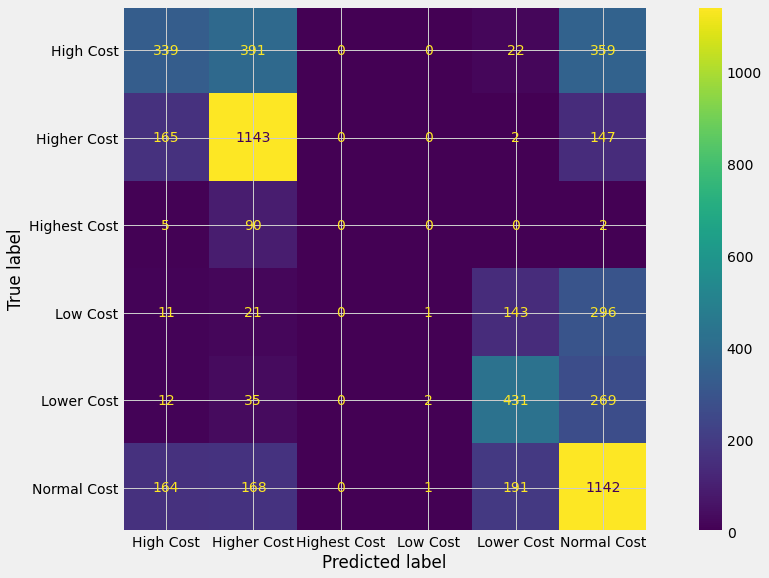

In [186]:
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
f, ax = plt.subplots(figsize=(16,9)
                    )
disp.plot(ax = ax)
plt.show();

In [187]:
sample = pd.read_csv("../input/ai4d-africas-anglophone-research/SampleSubmission.csv")
sample.head()

,Tour_ID,High Cost,Higher Cost,Highest Cost,Low Cost,Lower Cost,Normal Cost
0,tour_idynufedne,0.23,0.56,0.04,0.12,0.005,0.12
1,tour_id9r3y5moe,NaN,NaN,NaN,NaN,NaN,NaN
2,tour_idf6itml6g,NaN,NaN,NaN,NaN,NaN,NaN
3,tour_id99u4znru,NaN,NaN,NaN,NaN,NaN,NaN
4,tour_idj4i9urbx,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
test = test[features]
# Make prediction on the test set
predictions = model.predict_proba(test) 
predictionss =

array([[1.36309855e-01, 2.69549390e-02, 2.76341633e-04, 1.13776248e-01,
        7.43888393e-02, 6.48293777e-01],
       [2.48543271e-01, 5.36574053e-01, 1.15084190e-01, 6.81887318e-03,
        6.24784953e-03, 8.67317631e-02],
       [5.85086770e-01, 2.07361888e-01, 1.02597606e-02, 1.49162818e-02,
        6.94798019e-03, 1.75427319e-01],
       ...,
       [3.52358396e-01, 9.74323895e-02, 1.01230653e-02, 5.73219302e-02,
        8.85708753e-02, 3.94193344e-01],
       [4.52536823e-02, 4.39167305e-03, 2.14231653e-04, 1.64217753e-01,
        4.73137430e-01, 3.12785230e-01],
       [3.36873325e-02, 6.64416729e-03, 2.12901436e-04, 2.80802528e-01,
        2.78214553e-01, 4.00438518e-01]])

In [213]:
# Create a submission file
sub_file = sample.copy()
sub_file[['High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost',
       'Lower Cost', 'Normal Cost']] = predictions

sub_file.head()

,Tour_ID,High Cost,Higher Cost,Highest Cost,Low Cost,Lower Cost,Normal Cost
0,tour_idynufedne,0.136310,0.026955,0.000276,0.113776,0.074389,0.648294
1,tour_id9r3y5moe,0.248543,0.536574,0.115084,0.006819,0.006248,0.086732
2,tour_idf6itml6g,0.585087,0.207362,0.010260,0.014916,0.006948,0.175427
3,tour_id99u4znru,0.057425,0.004350,0.000150,0.276071,0.218738,0.443265
4,tour_idj4i9urbx,0.048494,0.005725,0.000128,0.212267,0.300782,0.432603


In [193]:
sub_file.columns

Index(['Tour_ID', 'High Cost', 'Higher Cost', 'Highest Cost', 'Low Cost',
       'Lower Cost', 'Normal Cost'],
      dtype='object')

In [214]:
sub_file.to_csv("kop.csv", index = False)